# How to use perplexity for VBEM selection in Salmon

## Introduction

RNA transcript abundance estimation is the standard computational method to count the number of RNA fragments in an RNA sample belonging to transcripts (for example, genes of interest). Counting RNAs is useful for downstream analysis such as differential expression, which computes the up- and down-regulation of the genes which produced the RNAs. Knowing which genes are more or less expressed can be useful for studying diseases such as cancer.

The RNA transcript abundance algorithm is this:

Input: RNA reads and a transcriptome.

Output: Expected value of fragments mappings to transcripts. Equivalenty, the expected number of RNAs generated per transcript in the transcriptome.

One RNA transcript quantification algorithm is [Salmon](https://www.nature.com/articles/nmeth.4197) which is developed by Professor Rob Patro (my PI) at UMD.

Salmon performs transcript quantification using Variational Bayes Expectation Maximization (VBEM) or Expectation Maximizaton (EM). When using VBEM, there is a hyperparameter, the per-nucleotide VBEM prior. From the Salmon [documentatation](https://salmon.readthedocs.io/en/latest/salmon.html#useem):

> The default prior used in the VB optimization is a per-nucleotide prior of 1e-5 reads per-nucleotide. This means that a transcript of length 100000 will have a prior count of 1 fragment, while a transcript of length 50000 will have a prior count of 0.5 fragments, etc.

This prior is essentially the background expression expected in this sample. A smaller prior size will result in a sparser estimate. A larger prior size will result in more non-zero estimates. It is important to select a VBEM prior that makes sense for the reads you want to quantify.

Thus, model selection through evaluating RNA abundance estimates is a learning problem. We could evaluate estimates directly with a known transcript expression distribution, aka the ground truth. But we usually don't have this ground truth. If we have simulated data, we can compare the transcript abundance quantification estimate (quant) with the ground truth from which we simulated our data from. But simulated reads are not as interesting as real reads extracted from cells. With real reads, we don't know the ground truth, in fact this is usually what we are trying to find out! We could use quantitative PCR to perform transcript quantification using fluorescent nucleotides. But qPCR is not the most reliable way to count RNAs, so most people send reads for sequencing instead of doing qPCR with them.

Since we can't rely on the the ground truth for evaluating transcript abundance estimates, let's evalute estimates without the ground truth! In other words, let's make hyperparameter selection an unsupervised learning problem. We described in a [paper](https://drops.dagstuhl.de/opus/volltexte/2021/14357/) how to perform model selection for transcript abundance estimation on experimental data in the absence of ground truth. The evaluation metric we used is an adaptation of perplexity from natural language processing to transcriptomics. In this context, perplexity is the inverse geometric mean _per-read_ likelihood of a held-out test set. To compute perplexity, we split our reads into a test set and training set. We compute an abundance estimate on the training set, holding out the test set. Then we compute perplexity on the abundance estimate and the held-out reads. The lower the perplexity, the better the abundance estimate describes the held-out reads. Therefore, perplexity is a proxy for the goodness of an abundance estimate, and as we show in the paper, perplexity can be used for hyperparameter selection. Figure 2 from our paper is a visual representation of what I described above.

![perplexity-figure2.png](attachment:perplexity-figure2.png)

The problem for hyperparemeter selection now becomes:

Input: RNA reads and a transcriptome.

Output: the best VBEM prior, which is the one that generates the abundance estimate with the smallest perplexity

In this tutorial I will demonstrate hyperparameter selection of the VBEM prior using perplexity using k-fold cross validation.

## Setup

Open a shell and clone the repository.

```sh
git clone https://github.com/schance995/perplexity.git
cd perplexity
git checkout tutorial
```

The source code for the `perplexity` program is included. It's written in Rust, which is a compiled language. If you don't have Rust installed already, download and run Rustup, which manages the Rust toolchain.

```sh
curl --proto '=https' --tlsv1.2 -sSf https://sh.rustup.rs -o rustup-installer.sh
# check that the script looks ok
less ./rustup-installer.sh
# run the installer
sh ./rustup-installer.sh
# download the stable Rust toolchain
rustup default stable
```

Once you have installed Rust, compile the perplexity binary.

```sh
cargo build --release
```

Next we'll install some Conda packages. One drawback of Conda is that it resolves even simple dependencies very slowly. One solution is [Mamba](https://github.com/mamba-org/mamba) resolves dependencies faster. You can install mamba if you already have Conda, otherwise check the [installation guide]((https://github.com/mamba-org/mamba#installation)).

```sh
conda install mamba -n base -c conda-forge
```

Mamba has a limitation <https://github.com/mamba-org/mamba/issues/633#issuecomment-812272143> where it cannot create new environments from an environment file. As a workaround, create a new environment, then update it with `env.yml`:

```sh
conda env create -n tutorial
mamba env update -n tutorial --file env.yml
```

Activate the environment to make the programs available in your path.

```sh
conda activate tutorial
```

Now we are ready to configure the pipeline.

## Configuration

We use [Snakemake](https://snakemake.github.io), which is "a framework for reproducible data analysis". Think GNU Make, but for data science. It helps us run parallel, reproducible pipelines. Snakemake will generate all output files from input files and will run the intermediate steps in the correct order.

Before running the pipeline, edit the configuration file, `snakefiles/config.yml` to declare the inputs to the analysis.
```yaml
# results will go in {out-dir}/{exp-name}
out-dir: output
exp-name: tutorial

# expects paired end reads with format:
#    {reads-dir}/{sample_name}_1.fasta
#    {reads-dir}/{sample_name}_2.fasta
read_file_fmt: fasta
# replace with your reads directory
reads-dir: /fs/cbcb-lab/rob/students/jason/shared/SRR1265495/
# replace with your sample names to quantify
sample-names:
  - sample_01

# Path to reference transcriptome for salmon (replace with your transcriptome)
txome-path: /fs/cbcb-lab/rob/students/jason/shared/annotations/hg19_clean.fa

# where to find folds, recommended to put this in {current working directory}/output/tutorial/folds
# for example my working directory is /fs/cbcb-lab/rob/students/skylar/perplexity
folds-dir: /fs/cbcb-lab/rob/students/skylar/perplexity/output/tutorial/folds

# Path to perplexity binary, and kfolds.sh script
perplexity-bin: target/release/perplexity
kfold-script: scripts/kfolds.sh

# Number of folds
k: 5

# VBEM priors to test with
prior-weights:
  - 1e-6
  - 1e-5
  - 1e-4
  - 1e-3
  - 1e-2
  - 1e-1
  - 1e0
  - 1e1
  - 1e2
  - 2
  - 3
  - 4
  - 5
  - 6
  - 7 
  - 8
  - 9
```

## Run the pipeline

### kfolds

The first step of the pipeline is to create k folds for cross-validation. Specify the snakefile to run with --snakefile and the config file you wrote earlier with --configfile. It is a good idea to use the `-n` flag to simulate the run and conserve CPU cycles and disk writes.

```sh
# check the files that this snakefile will produce
snakemake --snakefile snakefiles/kfold.snk --configfile <config file> -n
```
The proposed output should list the rules that will be run and the files that will be generated from this Snakefile. This Snakefile will prepare train and test sets suitable for k-fold cross-validation. It simply calls a helper script (`kfold.sh`) to achieve this [<sup>1</sup>](#fn1). It will multiply the disk space used by your reads by $k$, which should not be a problem for a cluster but might be a problem for a small hard drive.

When you are ready to run the snakefile, remove `-n` and add `-j <n cores>` to the command, where `n cores` is the number of cores you want run Snakemake with. If you specify `-j` without a number, you will use all available cores, which is fine if you are on your laptop [<sup>1</sup>](#fn1).

```sh
# run the pipeline for real
snakemake --snakefile snakefiles/kfold.snk --configfile <config file> -j <n cores>
```

This will take a few minutes depending on the size of your data.

### Transcript quantification and perplexity calculation

After the kfolds snakefile is finished, let's do the same yoga for the perplexity snakefile.

```sh
# check the files that this snakefile will produce
snakemake --snakefile snakefiles/perplexity.snk --configfile <config file> -n
```

There are many steps to this snakefile. First, the transcriptome will be indexed. Then Salmon will compute transcript abundance estimates for each fold and VBEM. Finally perplexity will be computed using the `perplexity` binary.

```sh
# run the pipeline for real
snakemake --snakefile snakefiles/perplexity.snk --configfile <config file> -j <n jobs>
```

This will take longer than creating the k-folds, so you might want to grab a cup of coffee (or tea).

### Plot VBEM vs perplexity

To perform hyperparameter selection with perplexity, let's run the plots below.

In [65]:
# import packages
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import yaml

%matplotlib inline

In [66]:
perp_fp_fmt = '../output/tutorial/perplexity/{sample}/vbprior={vb_prior}/beta=1e-8/{fold}/perplexity.yml'
tpm_fmt = '../output/tutorial/quants/{sample}/vbprior={vb_prior}/{fold}/quant.sf'

exp_config = '../snakefiles/config.yml'
with open(exp_config, 'r') as f:
    cfg = yaml.safe_load(f)
    SAMPLES = cfg['sample-names']
    K = cfg['k']
    VB_PRIORS = [str(w) for w in cfg['prior-weights']]

## Perplexities

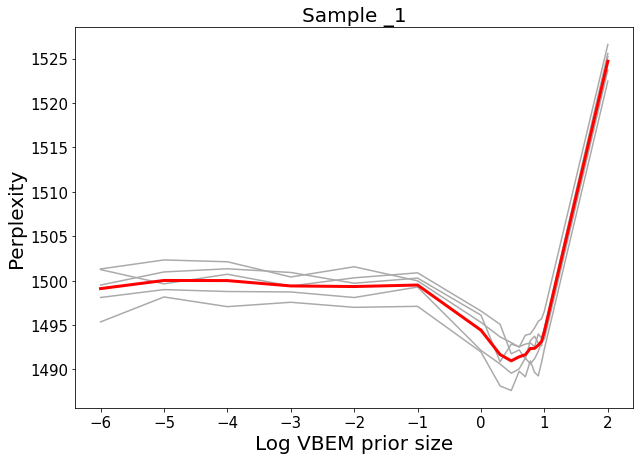

The smallest perplexity is 1487
The smallest VBEM is 3.0


In [64]:
def perplexity_plot(sample, vb_priors, folds):
    df = pd.DataFrame()
    for vb_prior in vb_priors:
        for fold in range(1, folds + 1):
            with open(perp_fp_fmt.format(sample=sample, vb_prior=vb_prior, fold=fold), 'r') as f:
                perp_result = yaml.safe_load(f)
            _vb_prior = float(vb_prior)
            df = df.append(dict(perplexity=perp_result['smoothed_perplexity'],
                                vb_prior=_vb_prior, log_vb_prior = np.log10(_vb_prior),
                                fold=fold), 
                           ignore_index=True)

    # find the minimum value in the df and convert to base 10 (not in logs)
    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ax.set_title('Sample {}{}'.format(sample[-3], sample[-1]), fontsize=20)
    sns.lineplot(x="log_vb_prior", y="perplexity", data=df, ax=ax, units="fold", estimator=None, color='#AAAAAA')
    sns.lineplot(x="log_vb_prior", y="perplexity", data=df, ax=ax, err_style=None, lw=3, color="red")

    ax.set_ylabel('Perplexity', fontsize=20)
    ax.set_xlabel('Log VBEM prior size', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=15)

    plt.show()
    small = df.nsmallest(1, 'perplexity')
    print('The smallest perplexity is ' + str(int(small['perplexity'].values[0])))
    print('The smallest VBEM is ' + str(10**small['log_vb_prior'].values[0]))
    return ax

for sample in SAMPLES:
    perplexity_plot(sample, VB_PRIORS, 5)

Now we need to interpret this plot. It's log VBEM prior size to perplexity. The minimum perplexity is present between 0 and 1, and for this example the smallest VBEM is 3. So we should run Salmon with --vbprior = 3 for running transcript quantification. This result can be used for downstream applications. Note that a new vbprior should be selected for every sample. (demonstrate this perhaps with the read depth thing)

## What about the read depth?

The hypothesis is that VB prior will change depending on the size. This time we'll use holdout evaluation on samples of 10 to 80 million reads, using a a test set of 20 million reads. We'll keep the test set the same for each sample.

For this one I will simulate reads with polyester <span id="fn2">2.</span>. Polyester only simulates a fixed number of reads dependent on the size of the quant matrix input. In this instance each simulated sample is 14.7 million reads. To achieve a simulated sample of 100 million reads, 7 samples are generated and concatenated together, discarding extra reads.

Just run the snakefile to create 8 samples from 10 to 80 million reads and a test sample of 20 million reads.

Then run combine_polyester to combine them together.

Hopefully this works

TODO: this might not work. Should use our pool of 7 reads, 1 2 3 4 5 6, instead of counting them all. just cat
1
12
123
1234
12345
123456

and use 7 to train them all

Simulating reads can also take a while, maybe go get some lunch.

Rerun the snakefile with an additional rule.

TODO: Write a new snakefile :P

In [71]:
perp_fp_fmt = '../output/read_depth/perplexity/{sample}/vbprior={vb_prior}/beta=1e-8/perplexity.yml'
tpm_fmt = '../output/read_depth/quants/{sample}/vbprior={vb_prior}/quant.sf'

exp_config = '../snakefiles/config-readdepth.yml'
with open(exp_config, 'r') as f:
    cfg = yaml.safe_load(f)
    SAMPLES = cfg['sample-names']
    VB_PRIORS = [str(w) for w in cfg['prior-weights']]

for sample in SAMPLES:
    perplexity_plot(sample, VB_PRIORS, 5)

FileNotFoundError: [Errno 2] No such file or directory: '../output/read_depth/perplexity/10_million_reads/vbprior=1e-6/beta=1e-8/perplexity.yml'

TODO: something witty and inspirational about these plots

## Conclusion

In this tutorial we demonstrated hyperparameter selection with RNA perplexity. We also looked into read depth.

The most important takeaways are:

1. perplexity works with vbem prior

2. perplexity will differ for every sample

3. perplexity will differ with read depth.

Perplexity is not a one-size fits all approach, but can help produce better RNA transcript abundance estimates.

## Footnotes
<span id="fn1">1.</span> It should be noted that currently the kfold.sh script does not work for all input data. A Rust rewrite for correct functionality and improved performance is planned for the future.

<span id="fn2">2.</span> You can run snakemake with all cores if you want to annoy everyone on the cluster :)

<span id="fn2">3.</span> ??